# ENHANCING E-COMMERCE USING AN ADVANCED SEARCH ENGINE AND RECOMMENDATION SYSTEM

In [ ]:
#Let’s import all the libraries required
#Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#NLP for text pre-processing
import nltk
import scipy
import re
from scipy import spatial
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
tokenizer = ToktokTokenizer()

In [ ]:
# other libraries
import gensim
from gensim.models import Word2Vec
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [ ]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
# remove warnings
import warnings
warnings.filterwarnings(action = 'ignore')

In [ ]:
data=pd.read_csv("flipkart_com-ecommerce_sample.csv")
data.head()
data.shape

(20000, 15)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  20000 non-null  object 
 1   crawl_timestamp          20000 non-null  object 
 2   product_url              20000 non-null  object 
 3   product_name             20000 non-null  object 
 4   product_category_tree    20000 non-null  object 
 5   pid                      20000 non-null  object 
 6   retail_price             19922 non-null  float64
 7   discounted_price         19922 non-null  float64
 8   image                    19997 non-null  object 
 9   is_FK_Advantage_product  20000 non-null  bool   
 10  description              19998 non-null  object 
 11  product_rating           20000 non-null  object 
 12  overall_rating           20000 non-null  object 
 13  brand                    14136 non-null  object 
 14  product_specifications

Here are the observations.
• The data set has a total of 15 columns and 20,000 observations.
• is_FK_Advantage_product is a boolean, the retail_price and discounted_price columns are numerical, and the remaining are categorical.

In [ ]:
data['length']=data['description'].str.len()

In [ ]:
data['no_of_words'] = data.description.apply(lambda x : len(str(x).split()))

In [ ]:
bins=[0,50,75, np.inf]
data['bins']=pd.cut(data.no_of_words, bins=[0,100,300,500,800, np.inf],
                    labels=['0-100', '100-200', '200-500','500-800' ,'>800'])


In [ ]:
words_distribution = data.groupby('bins').size().reset_index(). rename(columns={0:'word_counts'})

Text(0.5, 1.0, 'Word distribution per bin')

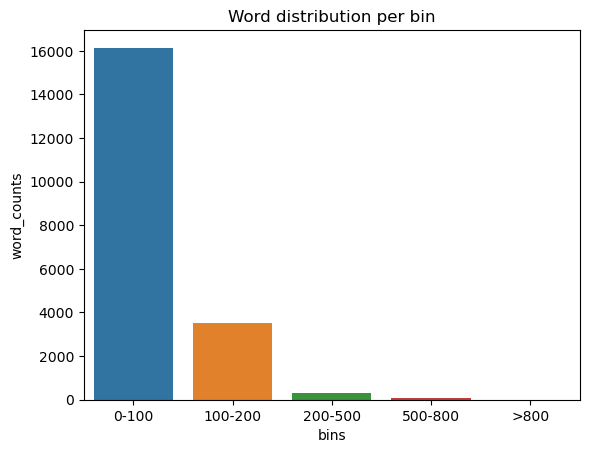

In [ ]:
sns.barplot(x='bins', y='word_counts', data=words_distribution).set_title ("Word distribution per bin")

Shows that most descriptions have less than 100 words and 20% have 100 to 200 words.

Data Preprocessing
Data preprocessing includes data cleaning, preparation, transformation, and dimensionality reduction, which convert the raw data into a form that is suitable for further processing.

In [ ]:
# Number of missing values in each column
missing = pd.DataFrame(data.isnull().sum()).rename(columns = {0:'missing'})

In [ ]:
# Create a percentage of missing values
missing['percent'] = missing['missing'] / len(data)

In [ ]:
# sorting the values in desending order to see highest count on the top
missing.sort_values('percent', ascending = False)

,missing,percent
brand,5864,0.29320
retail_price,78,0.00390
discounted_price,78,0.00390
product_specifications,14,0.00070
image,3,0.00015
length,2,0.00010
description,2,0.00010
uniq_id,0,0.00000
product_rating,0,0.00000
no_of_words,0,0.00000


shows that nearly 30% of the brand variables have missing values. Other variables have a negligible number of missing values.

Text  Preprocessing
There is a lot of unwanted information present in the text data. Let’s clean it up.
Text preprocessing tasks include
• Converting the text data to lowercase
• Removing/replacing the punctuations
• Removing/replacing the numbers
• Removing extra whitespaces
• Removing stop words
• Stemming and lemmatization

In [ ]:
# Remove punctuation
data['description'] = data['description'].str.replace(r'[^\w\d\s]', ' ')
# Replace whitespace between terms with a single space
data['description'] = data['description'].str.replace(r'\s+', ' ')
# Remove leading and trailing whitespace
data['description'] = data['description'].str.replace(r'^\s+|\s+?$', '')
# converting to lower case
data['description'] = data['description'].str.lower()

In [ ]:
data['description'].head()

0    key features of alisha solid women s cycling s...
1    fabhomedecor fabric double sofa bed finish col...
2    key features of aw bellies sandals wedges heel...
3    key features of alisha solid women s cycling s...
4    specifications of sicons all purpose arnica do...
Name: description, dtype: object

In [ ]:
# Removing Stop words
stop = stopwords.words('english')
pattern = r'\b(?:{})\b'.format('|'.join(stop))
data['description'] = data['description'].str.replace(pattern, '')

In [ ]:
# Removing single characters
data['description'] = data['description'].str.replace(r'\s+', ' ')
data['description'] = data['description'].apply(lambda x: " ".join(x for x in str(x).split() if len(x)>1))

In [ ]:
# Removing domain related stop words from description
specific_stop_words = [ "rs","flipkart","buy","com","free","day","cash","re placement","guarantee",
                       "genuine","key","feature","delivery","products","pro duct","shipping",
                       "online","india","shop"]
data['description'] = data['description'].apply(lambda x: " ".join(x for x in str(x).split() if x not in specific_stop_words))

In [ ]:
data['description'].head()

0    features alisha solid women cycling shorts cot...
1    fabhomedecor fabric double sofa bed finish col...
2    features aw bellies sandals wedges heel casual...
3    features alisha solid women cycling shorts cot...
4    specifications sicons purpose arnica dog shamp...
Name: description, dtype: object

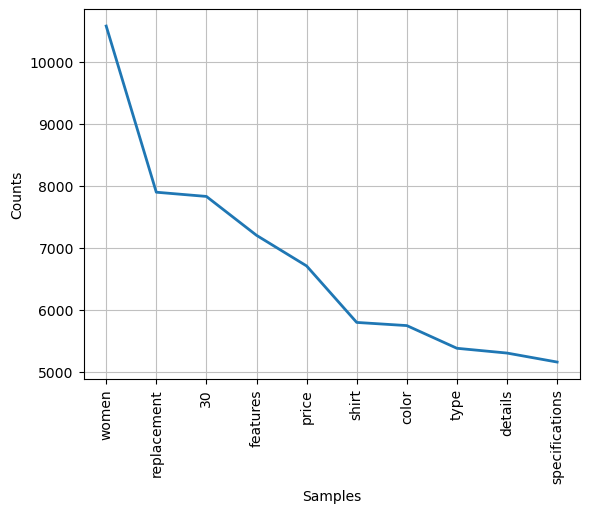

[('women', 10574), ('replacement', 7894), ('30', 7826), ('features', 7199), ('price', 6705), ('shirt', 5794), ('color', 5743), ('type', 5377), ('details', 5300), ('specifications', 5155)]


In [ ]:
#Let’s also see what are the most occurred words in the corpus and understand the data better.
#Top frequent words after removing domain related stop words
a = data['description'].str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)
word_dist.plot(10,cumulative=False)
print(word_dist.most_common(10))

Shows that data has words like women, price, and shirt appeared commonly in the data because there are a
lot of fashion-related items and most of it is for women.

# Model Building
There are two models we want to build.
• A content-based recommendation system
• A product search engine

In [ ]:
#Content-based Recommendation System
#Now that you know about content-based recommender systems, let’s start implementing one.
#For content-based systems, let’s use the TF-IDF approach.
#text cleaning
data['description'] = data['description'].fillna('')
#define the vectorizer
T_vec =  TfidfVectorizer(stop_words='english')
# get the vectors
T_vec_matrix = T_vec.fit_transform(data['description'])
#shape
T_vec_matrix.shape

(20000, 26165)

There are 26,000 unique words in the description.
Next, let’s calculate similarity scores for each combination and generate matrix. A cosine similarity is used in this project. We need to write a function that takes
product descriptions as input and lists N most similar items/products.
We also need to do reverse mapping of product names to their indices.

In [ ]:
# Reversing the map of indices and product
product_index = pd.Series(data.index, index=data['product_name']).drop_duplicates()
product_index

product_name
Alisha Solid Women's Cycling Shorts            0
FabHomeDecor Fabric Double Sofa Bed            1
AW Bellies                                     2
Alisha Solid Women's Cycling Shorts            3
Sicons All Purpose Arnica Dog Shampoo          4
                                           ...  
WallDesign Small Vinyl Sticker             19995
Wallmantra Large Vinyl Stickers Sticker    19996
Elite Collection Medium Acrylic Sticker    19997
Elite Collection Medium Acrylic Sticker    19998
Elite Collection Medium Acrylic Sticker    19999
Length: 20000, dtype: int64

In the following steps, everything is wrapped under a single function to make testing easier.
1. Obtain the index given the product.
2. Obtain cosine similarity scores.
3. Sort the scores.
4. Get the top N results from the list.
5. Output the product names

In [ ]:
from typing import List

In [ ]:
# Function that takes in product title as input and outputs the most similar product
def predict_products(text):
    #getting index
    index = product_index[text]

    #obtaining the pairwise similarity scores
    score_matrix = linear_kernel(T_vec_matrix[index], T_vec_matrix)
    matching_sc = list(enumerate(score_matrix[0]))
    #sort the product based on the similarity scores
    matching_sc = sorted(matching_sc, key = lambda x: x[1], reverse = True)

    # Getting the scores of the 10 most similar product
    matching_sc= matching_sc[1:10]
    # Getting the product indices
    product_indices = [i[0] for i in matching_sc]
    # Show the similar products
    return data['product_name'].iloc[product_indices]

In [ ]:
recommended_product = predict_products(input("Enter a product name: "))
if recommended_product is not None:
    print ("Similar products")
    print("\n")
    for product_name in recommended_product:
        print (product_name)

Enter a product name: Lee Parke Walking Shoes
Similar products


Lee Parke Running Shoes
N Five Running Shoes
WorldWearFootwear Running Shoes, Walking Shoes
Knight Ace Kraasa Sports Running Shoes, Cycling Shoes, Walking Shoes
Bootwale Walking Shoes
AMCO Walking Shoes
Next Player Walking Shoes
ASIAN Walking Shoes
reenak Running Shoes


Observe the results. If a customer clicks Lee Parke Running Shoes, they get recommendations based on any other brand running shoes or Lee Parke’s any other products.
• Lee Parke Walking Shoes is there because of the Lee Parke brand.
• The rest of the recommendations are running shoes by a different
brand.

# Product Search Engine

Let’s use the pretrained word2vec model on the news data set by Google.
The trained model can be imported, and vectors can be obtained for each word.
Then, any of the similarity measures can be leveraged to rank the results.

In [ ]:
#Creating list containing description of each product as sublist
fin=[]
for i in range(len(data['description'])):
    temp=[]
    temp.append(data['description'][i])
    fin = fin + temp

data1 = data[['product_name','description']]

In [ ]:
from gensim import models
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
filename = 'GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True,
limit=50000)

In [ ]:
file_path = 'GoogleNews-vectors-negative300.bin'

# Open the binary file for reading in binary mode ('rb')
with open(file_path, 'rb') as binary_file:
    # Read the contents of the binary file
    binary_data = binary_file.read()

# Process or display the binary data as needed
print(binary_data[:100])  # Print the first 100 bytes as an example


b'3000000 300\n</s> \x00\x00\x94:\x00\x00k\xba\x00\x00\xa79\x00\x00\xc9:\x00\x00\x91:\x00\x00\xb8\xba\x00\x00\x00\xb8\x00\x00\xdc\xb9\x00\x00\x17\xba\x00\x00\x8d:\x00\x00\x86\xba\x00\x00"\xba\x00\x00F\xba\x00\x00\xb8:\x00\x00\xd7\xba\x00\x00&\xba\x00\x00\xd6:\x00\x00\x84\xba\x00\x00\xa6\xba\x00\x00+:\x00\x00\xda'


In [ ]:
#Preprocessing
def remove_stopwords(text, is_lower_case=False):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text[0])
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [ ]:
import numpy as np
import nltk
import scipy
import pandas as pd


In [ ]:
# Obtain the embeddings, let's use "300"
def get_embedding(word):
    if word in model.key_to_index:
        return model.get_vector(word)
    else:
        return np.zeros(300)


In [ ]:
# Obtaining the average vector for all the documents
out_dict = {}
for sen in fin:
    average_vector = (np.mean(np.array([get_embedding(x) for x in nltk.word_tokenize(remove_stopwords(sen))]), axis=0))
    dict = { sen : (average_vector) }
    out_dict.update(dict)

For every document, let’s take the mean of all the words present in the document.

In [ ]:
import numpy as np
import scipy.spatial.distance

# Get the similarity between the query and documents
def get_sim(query_embedding, average_vector_doc):
    sim = 1 - scipy.spatial.distance.cosine(np.ravel(query_embedding), np.ravel(average_vector_doc))
    return sim


In [ ]:
# Rank all the documents based on the similarity
def Ranked_documents(query):
    global rank
    query_words =  (np.mean(np.array([get_embedding(x) for x in nltk.word_tokenize(query.lower())],dtype=float), axis=0))
    rank = []
    for k,v in out_dict.items():
        rank.append((k, get_sim(query_words, v)))
    rank = sorted(rank,key=lambda t: t[1], reverse=True)
    dd =pd.DataFrame(rank,columns=['Desc','score'])
    rankfin = pd.merge(data1,dd,left_on='description',right_on='Desc')
    rankfin = rankfin[['product_name','description','score']]
    print('Ranked Documents :')
    return rankfin

In [ ]:
# Call the IR function with a query
query=input("What would you like to search?: ")
Ranked_documents(query)

What would you like to search?: bag
Ranked Documents :


,product_name,description,score
0,Alisha Solid Women's Cycling Shorts,features alisha solid women cycling shorts cot...,0.107118
1,FabHomeDecor Fabric Double Sofa Bed,fabhomedecor fabric double sofa bed finish col...,0.107118
2,AW Bellies,features aw bellies sandals wedges heel casual...,0.107118
3,Alisha Solid Women's Cycling Shorts,features alisha solid women cycling shorts cot...,0.107118
4,Sicons All Purpose Arnica Dog Shampoo,specifications sicons purpose arnica dog shamp...,1.000000
...,...,...,...
19995,Wallmantra Large Vinyl Stickers Sticker,wallmantra large vinyl stickers sticker 1369 w...,0.113536
19996,Wallmantra Extra Large Vinyl Stickers Sticker,wallmantra extra large vinyl stickers sticker ...,0.113536
19997,Wallmantra Extra Large Vinyl Stickers Sticker,wallmantra extra large vinyl stickers sticker ...,0.113536
19998,Wallmantra Extra Large Vinyl Stickers Sticker,wallmantra extra large vinyl stickers sticker ...,0.113536
